In [1]:
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface



In [2]:
gravity = 9.81
Dh = 0.0158276279311347000000
perim = 0.07267978843558340
area = 0.000287587162368000000
temp_tolerance = 1e-10
max_temp_iterations = 1000
nZones=25
L0 = 0.0
L1 = 1.74
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)
pressure_bc = 0.0
T_bc = 900.0
mdot_bc = 0.15
fric = 'type1'
_dt = 1e321
fission_source = 1 # nu*sigmaF/k * flux
heat_source = [0.0]*nZones # heat source in W/m3
#################
# CHANNEL SETUPS
#################
ch = Channel(gravity=gravity,
             Dh=Dh,
             area=area,
             temp_tolerance=temp_tolerance,
             max_temp_iterations=max_temp_iterations,
             nZones=nZones,
             L0=L0,
             L1=L1,
             fluid=fluid,
             pressure_bc=pressure_bc,
             T_bc=T_bc,
             mdot_bc=mdot_bc,
             fric=fric,
             heat_source=heat_source)

upper_plenum = Channel(gravity=gravity,
                       Dh=Dh,
                       area=area,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0,
                       L1=0.15,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)

external_loop = Channel(gravity=gravity,
                       Dh=Dh,
                       area=area*100,
                       temp_tolerance=temp_tolerance,
                       max_temp_iterations=max_temp_iterations,
                       nZones=nZones,
                       L0=0,
                       L1=5.0,
                       fluid=fluid,
                       pressure_bc=pressure_bc,
                       T_bc=1.0,
                       mdot_bc=1.0,
                       fric='none',
                       heat_source=0.0)


# Interfaces to handle data passing from one channel to another.
ch_to_plenum = ChannelInterface(ch1=ch, ch2=upper_plenum)
plenum_to_ex = ChannelInterface(ch1=upper_plenum, ch2=external_loop)
ex_to_ch = ChannelInterface(ch1=external_loop, ch2=ch)

# Solution order - main channel -> plenum -> external loop -> channel
ch.solve_channel_TH(_dt=_dt)
ch_to_plenum.update_interface_conditions()

upper_plenum.solve_channel_TH(_dt=_dt)
plenum_to_ex.update_interface_conditions()

external_loop.solve_channel_TH(_dt=_dt)
ex_to_ch.update_interface_conditions()



# End



Channel solved after 1 iterations!
Channel solved after 2 iterations!
Channel solved after 2 iterations!


In [3]:
# DNP EQUATION
c1 = ScalarField(name='c1', initial_value=0.0, mesh=ch.mesh)

# KERNELS
c1_adv = AdvectionKernel(field=c1, mesh=ch.mesh, w=ch.velocity_faces, scheme='upwind', rho=1.0)
c1_decay = ImplicitReactionKernel(field=c1, mesh=ch.mesh,lam=0.5)

# BCS
bc = AdvectedInletFluxBC(field=c1, mesh=ch.mesh, boundary='lower', phi=1.0, w=ch.velocity_faces, rho=1.0)

# SOLVER
solver = BasicSolver(kernels=[c1_decay, c1_adv], bcs=[bc], field=c1)
solver.solve()

print(c1.T)


[0.86930114 0.75568447 0.65691737 0.57105902 0.49642226 0.43154043
 0.37513859 0.3261084  0.28348641 0.24643506 0.21422628 0.18622715
 0.16188747 0.14072896 0.12233585 0.10634669 0.0924473  0.08036454
 0.06986099 0.06073024 0.05279286 0.0458929  0.03989475 0.03468055
 0.03014784]


In [4]:
ch.velocity_faces.T

array([0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093, 0.23146093, 0.23146093, 0.23146093, 0.23146093,
       0.23146093])

In [5]:
ch.temp.T

array([900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900.])

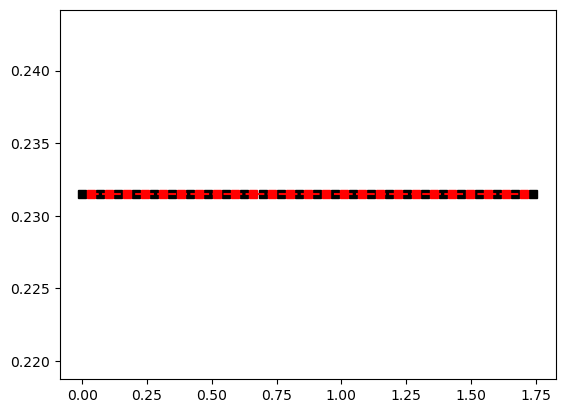

In [6]:
# velocities at faces and at centroids
plt.plot(ch.mesh.nodeCoords, ch.velocity_faces.T, 'k--s')
plt.plot(ch.mesh.centroids, ch.mdot.T / ch.rho.T / ch.area, 'r--s')

In [7]:
external_loop.temp.T

array([900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900.])

In [8]:
ch.T_bc

np.float64(899.9999999999995)

In [9]:
ch.b_energy

array([3846336.20689655,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
             0.        ])

In [10]:
ch.temp.T

array([900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900., 900., 900., 900., 900., 900., 900., 900., 900.,
       900., 900., 900.])

In [11]:
np.pi * Dh**2 / 4

0.00019675308308032713

In [12]:
0.18*area*2200

0.113884516297728

In [13]:
ch.heat_source

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [14]:
ch.h.T

array([1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700., 1784700., 1784700., 1784700., 1784700., 1784700.,
       1784700.])

In [15]:
ch.h_bc

np.float64(1784699.999999999)